# Template for analyzing the CLM5-PPE
- Updated August 3, 2021
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

## spin up some extra cores on CASPER

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
#only run once
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/work/dlawren/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36872 instead
  expected, actual


In [14]:
#note that you should eventually see your workers in the output here
# you can rerun this cell, to check that the job made it through the queue
client

<Client: 'tcp://10.12.206.54:42237' processes=20 threads=20, memory=465.60 GiB>

## A few useful functions

In [5]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [6]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [7]:
def param_effect(da,p,uniques,cf):
    nyrs=10

    x0      = (cf*month_wts(nyrs)*la*da).compute()
    x1      = 1/nyrs*x0.sum(dim='time').compute()
    
    mean    = x1.sum(dim='gridcell').compute()
    iav     = x0.sum(dim='gridcell').groupby('time.year').sum().std(dim='year').compute()
    xdefs   = np.array([mean.sel(ens=0).values,iav.sel(ens=0).values])

    
    effect_on_mean =[]
    effect_on_iav  =[]
    dxs            =[]
    for param in uniques:
        print(param)
        ix    = p==param
        xvals = x1.isel(ens=ix)
        mean2 = mean.isel(ens=ix)
        iav2  = iav.isel(ens=ix)
        
        if len(mean2)==2:
            #has min and max
            effect_on_mean.append(abs(mean2[0]-mean2[1]).values)
            effect_on_iav.append(abs(iav2[0]-iav2[1]).values)
            dxs.append(xvals[:,0]-xvals[:,1])
        else:
            #only has one or the other, sub in default x[0]
            effect_on_mean.append(abs(mean[0]-mean2[0]).values)
            effect_on_iav.append(abs(iav[0]-iav2[0]).values)
            dxs.append(x1.sel(ens=0)-xvals[:,0])

    dx      = xr.concat(dxs,dim='ens')
    r2      = np.corrcoef(dx)**2
    r2[np.isnan(r2)]=1   #this is to correct for BFBs
    spatial = r2.sum(axis=0)
            
    effect_on_mean = np.array(effect_on_mean)
    effect_on_iav  = np.array(effect_on_iav)

    return effect_on_mean,effect_on_iav,spatial,xdefs

In [8]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    ds = xr.open_dataset('/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0399.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [9]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True,preprocess=preprocess)

    #fix up time dimension
    ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

In [10]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2


## START HERE:

In [11]:
keys = paramkey.key.values
name = 'C285'
data_vars = ['GPP','HR','AR']
htape = 'h0'
ds = get_ensemble(name,data_vars,htape,keys,paramkey)

In [12]:
ds

<xarray.Dataset>
Dimensions:     (ens: 373, gridcell: 400, time: 120)
Coordinates:
  * time        (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    GPP         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    HR          (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    AR          (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    grid1d_lat  (gridcell) float64 ...
    grid1d_lon  (gridcell) float64 ...
    key         (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0398' 'OAAT0399'
    param       (ens) <U32 'default' 'taulnir' ... 'C2_liq_Brun89' 'om_frac_sf'
    minmax      (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 07/05/21 12:41:32
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n07_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn11_C285_OAAT0000
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                PPEn11_C285_postSASU_OAAT0000....
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_C285_OAAT0000.clm2.h3...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

<xarray.Dataset>
Dimensions:     (ens: 373, gridcell: 76, time: 120)
Coordinates:
  * time        (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    GPP         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 76), meta=np.ndarray>
    HR          (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 76), meta=np.ndarray>
    AR          (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 76), meta=np.ndarray>
    grid1d_lat  (gridcell) float64 61.58 61.58 61.58 61.58 ... 76.74 78.63 80.53
    grid1d_lon  (gridcell) float64 42.5 72.5 90.0 102.5 ... 337.5 17.5 17.5
    key         (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0398' 'OAAT0399'
    param       (ens) <U32 'default' 'taulnir' ... 'C2_liq_Brun89' 'om_frac_sf'
    minmax      (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 07/05/21 12:41:32
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n07_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn11_C285_OAAT0000
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                PPEn11_C285_postSASU_OAAT0000....
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_C285_OAAT0000.clm2.h3...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

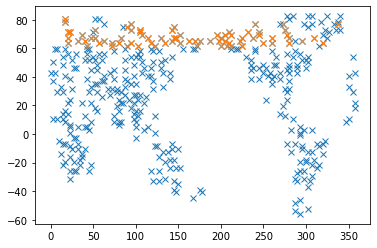

In [36]:
ix = (ds.grid1d_lat > 60) & (ds.grid1d_lat < 70) & (ds.grid1d_lon > 100) & (ds.grid1d_lon < 200)
ix = (ds.GPP.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > 60)
#ix = ds.GPP.isel(ens=0).mean(dim='time')>0

plt.plot(ds.grid1d_lon,ds.grid1d_lat,'x')
plt.plot(ds.grid1d_lon[ix],ds.grid1d_lat[ix],'x');
nx=ix.sum()
nx.values
temp = ds.isel(gridcell=ix)
temp

In [21]:
#how many gridcells above 60N with nonzero GPP
nx = (ds.GPP.isel(ens=0,gridcell=ix).mean(dim='time')>0).sum()
#plt.plot(ds.grid1d_lon,ds.grid1d_lat,'x')
#plt.plot(ds.grid1d_lon[nx],ds.grid1d_lat[nx],'x');

nx.values

array(76)

In [58]:
#use the landarea vector and month_wts to calculate average annual GPP
cf = 24*60*60*1e-9  #PgC
gpp_glob     = (la*ds.GPP).sum(dim='gridcell')
gpp_glob_ann = cf*(month_wts(10)*gpp_glob).groupby('time.year').sum()
gpp_avg      = gpp_glob_ann.mean(dim='year').compute()

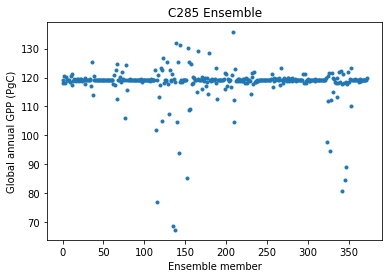

In [59]:
gpp_avg.plot.line('.')
plt.xlabel('Ensemble member')
plt.ylabel('Global annual GPP (PgC)')
plt.title('C285 Ensemble');

In [60]:
#which perturbations yield the bottom 10 lowest GPP?
print('LOW GPP:')
for i in np.argsort(gpp_avg)[:10]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

LOW GPP:
   jmaxb0-min
   lmrse-max
   medlynintercept-max
   lmrhd-min
   vcmaxse_sf-max
   kmax-min
   jmaxse_sf-max
   wc2wjb0-min
   tpuha-max
   vcmaxha-max


### look at the map of jmaxb0-min

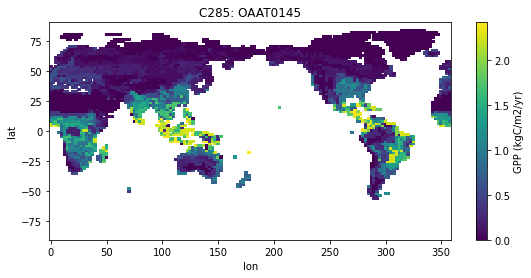

In [36]:
#find the given member
ix  = np.logical_and(ds.param=='jmaxb0',ds.minmax=='min')
da  = ds.GPP.isel(ens=ix) 

#calc annual gpp
nyrs = 10
cf   = 24*60*60/nyrs/1000
gpp  = cf*(month_wts(nyrs)*da).sum(dim='time').compute() #kgC/m2/yr

#convert to map
gpp_map = get_map(gpp)

#plot
plt.figure(figsize=[9,4])
gpp_map.plot(cbar_kwargs={'label':'GPP (kgC/m2/yr)'})
plt.title('C285: '+str(ds.key.isel(ens=ix).values[0]));

### calculate parameter effect
- i.e. max perturb -  min perturb

In [37]:
cf = 24*60*60*1e-9 #PgC
da = ds.GPP
uniques = ['kmax','krmax','psi50','ck']
mean,iav,spatial,xdefs=param_effect(da,ds.param,uniques,cf)

kmax
krmax
psi50
ck


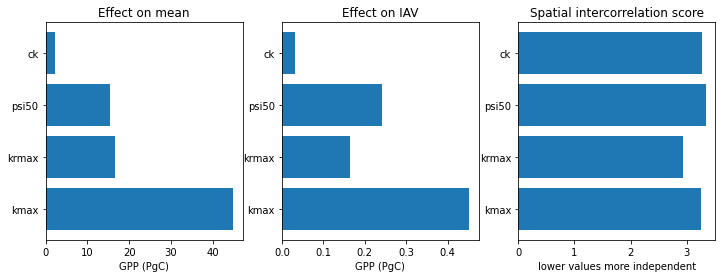

In [38]:
plt.figure(figsize=[12,4])
plt.subplot(131)
plt.barh(range(4),mean)
plt.yticks(range(4),uniques)
plt.xlabel('GPP (PgC)')
plt.title('Effect on mean');

plt.subplot(132)
plt.barh(range(4),iav)
plt.yticks(range(4),uniques)
plt.xlabel('GPP (PgC)')
plt.title('Effect on IAV');

plt.subplot(133)
plt.barh(range(4),spatial)
plt.yticks(range(4),uniques)
plt.xlabel('lower values more independent')
plt.title('Spatial intercorrelation score');